In [1]:
import pycal
import numpy as np
import matplotlib.pylab as plt
from pycal.mpi import MPI, Comm, get_world
from pycal.todmap import *
from pycal import Data

In [2]:
import os
import ipyparallel as ipp

c = ipp.Client()
v = c[:]
print(c.ids)
ar = c[:].apply_async(os.getpid)
pid_map = ar.get_dict()
view = c.load_balanced_view()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [3]:
communicator=MPI.COMM_WORLD
rank=communicator.Get_rank

In [4]:
azmin=(14/180)*np.pi
azmax=(36/180)*np.pi
elmin=(60/180)*np.pi
elmax=(80/180)*np.pi
tmin=0.0
tmax=2200.0
lmin_center=10
lmin_sigma=0
lmax_center=500
lmax_sigma=0
w_center=10
w_sigma=0
wdir_center=np.pi/6
wdir_sigma=0
z0_center=2000
z0_sigma=0
T0_center=280.0
T0_sigma=5.0
zatm=40000.0
zmax=2000.0
xstep=100.0
ystep=100.0
zstep=100.0
nelem_sim_max=200
verbosity=1
comm=communicator
key1=0
key2=1000+int(tmax)*25
counterval1=0
counterval2=0
cachedir="/tmp"
rmin=0
rmax=10000


if rank==0:
    env=pycal.Environment.get()
    print(env)
    
fs_hz=25
ss=(1/180)*np.pi
times=np.linspace(0,tmax,int(tmax)*fs_hz)
el=np.ones(int(tmax)*fs_hz)*(72/180)*np.pi
az=np.ones(int(tmax)*fs_hz)*(25/180)*np.pi

# azmin_tod=(20/180)*np.pi
# azmax_tod=(30/180)*np.pi
# az1=np.linspace(azmin_tod,azmax_tod,10*fs_hz)
# az=az1
# for i in range(0, int((tmax/10)-1)):
#     az1=np.flip(az1)
#     az=np.append(az, az1)
tod0=np.zeros(int(tmax)*fs_hz)
tod1=np.zeros(int(tmax)*fs_hz)
tod2=np.zeros(int(tmax)*fs_hz)
tod3=np.zeros(int(tmax)*fs_hz)
tod4=np.zeros(int(tmax)*fs_hz)

In [5]:
atm=pycal.AtmSimMPI(azmin, 
                    azmax, 
                    elmin, 
                    elmax, 
                    tmin, 
                    tmax, 
                    lmin_center, 
                    lmin_sigma, 
                    lmax_center, 
                    lmax_sigma, 
                    w_center, 
                    w_sigma, 
                    wdir_center, 
                    wdir_sigma, 
                    z0_center, 
                    z0_sigma, 
                    T0_center, 
                    T0_sigma, 
                    zatm, 
                    zmax, 
                    xstep, 
                    ystep, 
                    zstep, 
                    nelem_sim_max, 
                    verbosity, 
                    comm, 
                    key1, 
                    key2, 
                    counterval1, 
                    counterval2, 
                    cachedir, 
                    rmin, 
                    rmax
)

In [6]:
err = atm.simulate(False)
comm.Barrier()

In [7]:
atm.observe(times, az, el, tod2, -1)
comm.Barrier()

In [8]:
atm.observe(times, az, el-((5/180)*np.pi), tod0, -1)
comm.Barrier()

In [9]:
atm.observe(times, az, el+((5/180)*np.pi), tod1, -1)
comm.Barrier()

In [10]:
atm.observe(times, az+((5/180)*np.pi), el, tod3, -1)
comm.Barrier()

In [11]:
atm.observe(times, az-((5/180)*np.pi), el, tod4, -1)
comm.Barrier()

In [12]:
MPI.Finalize()

[]

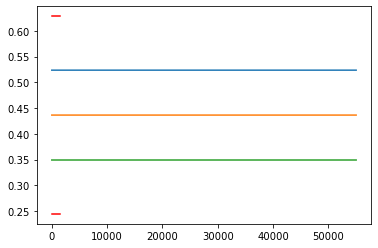

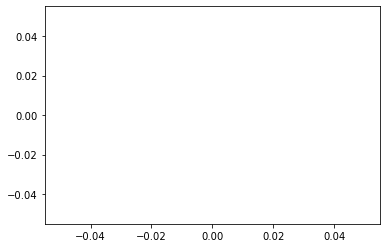

In [13]:
plt.figure(1)
plt.plot(az+((5/180)*np.pi))
plt.plot(az)
plt.plot(az-((5/180)*np.pi))
plt.plot([0,60*25], [azmin, azmin],'r-')
plt.plot([0,60*25], [azmax, azmax],'r-')

plt.figure(2)
plt.plot()

0.0048664100027272505


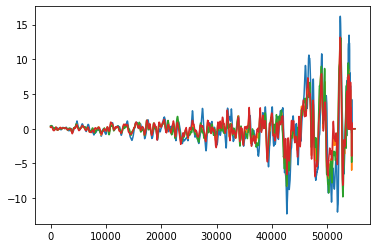

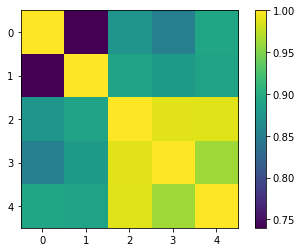

In [14]:
vmin = 1e30
vmax = -1e30
vmin = min(vmin, np.amin(tod0))
vmax = max(vmax, np.amax(tod0))
absorption=pycal.atm_absorption_coefficient(5400, 280, 101500, 2, 43)
print(absorption)
plt.figure(1)
plt.plot(tod0*absorption/1000 - tod1*absorption/1000, '-')
plt.plot(tod0*absorption/1000 - tod2*absorption/1000, '-')
plt.plot(tod0*absorption/1000 - tod3*absorption/1000, '-')
plt.plot(tod0*absorption/1000 - tod4*absorption/1000, '-')
# plt.plot(tod1*absorption/1000, '-')
# plt.plot(tod2*absorption/1000, '-')
# plt.plot(tod3*absorption/1000, '-')
# plt.plot(tod4*absorption/1000, '-')


tod0_fft=np.fft.fftshift(np.fft.fft(tod0))
tod1_fft=np.fft.fftshift(np.fft.fft(tod1))
tod2_fft=np.fft.fftshift(np.fft.fft(tod2))
tod3_fft=np.fft.fftshift(np.fft.fft(tod3))
tod4_fft=np.fft.fftshift(np.fft.fft(tod4))

cx00 = np.sum(np.abs(np.fft.ifftshift(np.fft.ifft(tod0_fft * np.conjugate(tod0_fft)))))

cx10 = np.sum(np.abs(np.fft.ifftshift(np.fft.ifft(tod1_fft * np.conjugate(tod0_fft)))))
cx20 = np.sum(np.abs(np.fft.ifftshift(np.fft.ifft(tod2_fft * np.conjugate(tod0_fft)))))
cx30 = np.sum(np.abs(np.fft.ifftshift(np.fft.ifft(tod3_fft * np.conjugate(tod0_fft)))))
cx40 = np.sum(np.abs(np.fft.ifftshift(np.fft.ifft(tod4_fft * np.conjugate(tod0_fft)))))

cx11 = np.sum(np.abs(np.fft.ifftshift(np.fft.ifft(tod1_fft * np.conjugate(tod1_fft)))))
cx21 = np.sum(np.abs(np.fft.ifftshift(np.fft.ifft(tod2_fft * np.conjugate(tod1_fft)))))
cx31 = np.sum(np.abs(np.fft.ifftshift(np.fft.ifft(tod3_fft * np.conjugate(tod1_fft)))))
cx41 = np.sum(np.abs(np.fft.ifftshift(np.fft.ifft(tod4_fft * np.conjugate(tod1_fft)))))

cx12 = np.sum(np.abs(np.fft.ifftshift(np.fft.ifft(tod1_fft * np.conjugate(tod2_fft)))))
cx22 = np.sum(np.abs(np.fft.ifftshift(np.fft.ifft(tod2_fft * np.conjugate(tod2_fft)))))
cx32 = np.sum(np.abs(np.fft.ifftshift(np.fft.ifft(tod3_fft * np.conjugate(tod2_fft)))))
cx42 = np.sum(np.abs(np.fft.ifftshift(np.fft.ifft(tod4_fft * np.conjugate(tod2_fft)))))

cx13 = np.sum(np.abs(np.fft.ifftshift(np.fft.ifft(tod1_fft * np.conjugate(tod3_fft)))))
cx23 = np.sum(np.abs(np.fft.ifftshift(np.fft.ifft(tod2_fft * np.conjugate(tod3_fft)))))
cx33 = np.sum(np.abs(np.fft.ifftshift(np.fft.ifft(tod3_fft * np.conjugate(tod3_fft)))))
cx43 = np.sum(np.abs(np.fft.ifftshift(np.fft.ifft(tod4_fft * np.conjugate(tod3_fft)))))

cx14 = np.sum(np.abs(np.fft.ifftshift(np.fft.ifft(tod1_fft * np.conjugate(tod4_fft)))))
cx24 = np.sum(np.abs(np.fft.ifftshift(np.fft.ifft(tod2_fft * np.conjugate(tod4_fft)))))
cx34 = np.sum(np.abs(np.fft.ifftshift(np.fft.ifft(tod3_fft * np.conjugate(tod4_fft)))))
cx44 = np.sum(np.abs(np.fft.ifftshift(np.fft.ifft(tod4_fft * np.conjugate(tod4_fft)))))

cx01 = np.sum(np.abs(np.fft.ifftshift(np.fft.ifft(tod0_fft * np.conjugate(tod1_fft)))))
cx02 = np.sum(np.abs(np.fft.ifftshift(np.fft.ifft(tod0_fft * np.conjugate(tod2_fft)))))
cx03 = np.sum(np.abs(np.fft.ifftshift(np.fft.ifft(tod0_fft * np.conjugate(tod3_fft)))))
cx04 = np.sum(np.abs(np.fft.ifftshift(np.fft.ifft(tod0_fft * np.conjugate(tod4_fft)))))


fp_cx=np.zeros((5,5))
# fp_cx[0,0] += cx00
# fp_cx[0,1] += cx01
# fp_cx[0,2] += cx02
# fp_cx[0,3] += cx03
# fp_cx[0,4] += cx04

# fp_cx[1,0] += cx10
# fp_cx[2,0] += cx20
# fp_cx[3,0] += cx30
# fp_cx[4,0] += cx40

# fp_cx[1,1] += cx11
# fp_cx[2,1] += cx21
# fp_cx[3,1] += cx31
# fp_cx[4,1] += cx41

# fp_cx[1,2] += cx12
# fp_cx[2,2] += cx22
# fp_cx[3,2] += cx32
# fp_cx[4,2] += cx42

# fp_cx[1,3] += cx13
# fp_cx[2,3] += cx23
# fp_cx[3,3] += cx33
# fp_cx[4,3] += cx43

# fp_cx[1,4] += cx14
# fp_cx[2,4] += cx24
# fp_cx[3,4] += cx34
# fp_cx[4,4] += cx44

fp_cx[0,0]=np.corrcoef(tod0,tod1)[0,0]
fp_cx[0,1]=np.corrcoef(tod0,tod1)[0,1]
fp_cx[1,0]=np.corrcoef(tod0,tod1)[1,0]
fp_cx[1,1]=np.corrcoef(tod0,tod1)[1,1]


fp_cx[2,2]=np.corrcoef(tod2,tod3)[0,0]
fp_cx[2,3]=np.corrcoef(tod2,tod3)[0,1]
fp_cx[3,2]=np.corrcoef(tod2,tod3)[1,0]
fp_cx[3,3]=np.corrcoef(tod2,tod3)[1,1]

fp_cx[4,4]=np.corrcoef(tod4,tod0)[0,0]
fp_cx[4,0]=np.corrcoef(tod4,tod0)[0,1]
fp_cx[0,4]=np.corrcoef(tod4,tod0)[1,0]

fp_cx[0,2]=np.corrcoef(tod0,tod2)[0,1]
fp_cx[2,0]=np.corrcoef(tod0,tod2)[1,0]

fp_cx[0,3]=np.corrcoef(tod0,tod3)[0,1]
fp_cx[3,0]=np.corrcoef(tod0,tod3)[1,0]

fp_cx[1,2]=np.corrcoef(tod1,tod2)[0,1]
fp_cx[2,1]=np.corrcoef(tod1,tod2)[1,0]

fp_cx[1,3]=np.corrcoef(tod1,tod3)[0,1]
fp_cx[3,1]=np.corrcoef(tod1,tod3)[1,0]

fp_cx[1,4]=np.corrcoef(tod1,tod4)[0,1]
fp_cx[4,1]=np.corrcoef(tod1,tod4)[1,0]

fp_cx[2,3]=np.corrcoef(tod2,tod3)[0,1]
fp_cx[3,2]=np.corrcoef(tod2,tod3)[1,0]

fp_cx[2,4]=np.corrcoef(tod2,tod4)[0,1]
fp_cx[4,2]=np.corrcoef(tod2,tod4)[1,0]

fp_cx[3,4]=np.corrcoef(tod3,tod4)[0,1]
fp_cx[4,3]=np.corrcoef(tod3,tod4)[1,0]
plt.figure(2)
plt.imshow(fp_cx)
plt.colorbar()

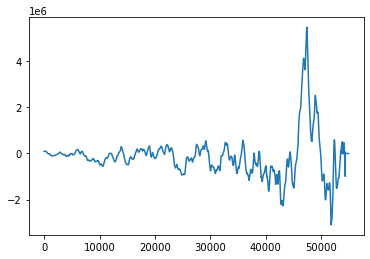

In [18]:
plt.plot(tod0)

In [12]:
abso_vec=pycal.atm_absorption_coefficient_vec(5000, 280, 101500, 5, 40, 50, 500)
load_vec=pycal.atm_atmospheric_loading_vec(5000, 280, 101500, 5, 40, 50, 500)


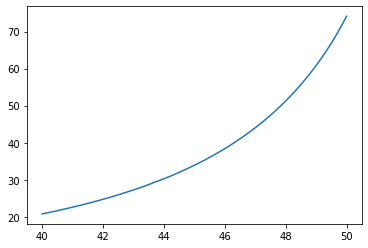

In [13]:
#plt.plot(np.linspace(40, 50, 500), abso_vec)
plt.plot(np.linspace(40, 50, 500), load_vec)

In [14]:
a=pycal.atm_absorption_coefficient(5000, 280, 101500, 2, 150)
b=pycal.atm_atmospheric_loading(5000, 280, 101500, 2, 57)

In [15]:
print(a,b)

0.06043288090984156 277.6659993620258


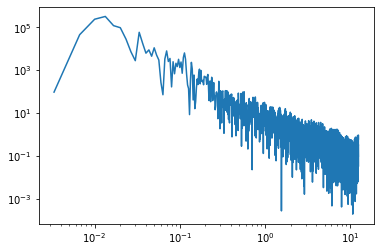

In [40]:
fmin=1/300
fmax=12.5
freq=np.linspace(fmin,fmax,int(len(tod_k)/2))
tod_k_fft=np.fft.fftshift(np.fft.fft(tod_k))
plt.loglog(freq,np.real(tod_k_fft[int(len(tod_k)/2)::])**2 + np.imag(tod_k_fft[int(len(tod_k)/2)::])**2)

In [32]:
1/170

0.0058823529411764705

In [33]:
1/0.012

83.33333333333333

In [34]:
1/25

0.04

In [35]:
1/0.04

25.0

In [36]:
tmax/5

36.0

In [52]:
def get_comm():
    log = pycal.Logger.get()
    env = pycal.Environment.get()
    mpiworld, procs, rank = get_world()

    # This is the 2-level toast communicator.  By default,
    # there is just one group which spans MPI_COMM_WORLD.
    comm = Comm(world=mpiworld)
    return mpiworld, procs, rank, comm

In [53]:
mpiworld, procs, rank, comm = get_comm()
atmsim=OpSimAtmosphere()

In [58]:
dati=Data(comm)
dati.comm

<cal.Comm
  World MPI communicator = <mpi4py.MPI.Intracomm object at 0x7f6b2b743c90>
  World MPI size = 1
  World MPI rank = 0
  Group MPI communicator = <mpi4py.MPI.Intracomm object at 0x7f6b2b743c90>
  Group MPI size = 1
  Group MPI rank = 0
  Rank MPI communicator = <mpi4py.MPI.Intracomm object at 0x7f6b2b743c70>
>

In [59]:
atmsim.exec(dati)

UnboundLocalError: local variable 'comm' referenced before assignment

In [ ]:
:>